# Import Libraries

In [196]:
import numpy as np
import pandas as pd
import joblib
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import pandas as pd
import re
import os

In [4]:
#sonia's machine
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2023-11-14 23:02:13.430941: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 23:02:13.430966: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 23:02:13.430990: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 23:02:13.437147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-11-14 23:02:16.548100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 23:02:16.548280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 23:02:16.594837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Load Combined Data

In [98]:
%cd /media/joeymeyer/970-evo-plus/Sonia/bertproj/combine/final_output/
%ls

/media/joeymeyer/970-evo-plus/Sonia/bertproj/combine/final_output
combined_df.pkl*                    final_topic_results.pkl*
conversational/                     final_topic_visualization.png*
final_bertopic_model.pkl*           travel_conversations.pkl*
final_heatmap_visualization.png*    travel_conversations_sample.pkl*
final_hierarchy_visualization.png*  travel_QA/
final_processed_with_topic.csv*     travel_QA.pkl*


/media/joeymeyer/970-evo-plus/Sonia/bertproj/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [99]:
output_dir = '/media/joeymeyer/970-evo-plus/Sonia/bertproj/rec_sys'

In [213]:
%cd /media/joeymeyer/970-evo-plus/Sonia/bertproj/combine/final_output/
qa = joblib.load('travel_QA.pkl')
qa = qa.reset_index(drop=True)
qa.shape

/media/joeymeyer/970-evo-plus/Sonia/bertproj/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/media/joeymeyer/970-evo-plus/Sonia/bertproj/combine/final_output


(4434, 6)

In [214]:
conv.head()

NameError: name 'conv' is not defined

In [215]:
conv['data'] = conv['data'].astype(str)

NameError: name 'conv' is not defined

In [216]:
# Function to safely evaluate the string as a list
def safe_eval(s):
    try:
        return ast.literal_eval(s)
    except (SyntaxError, ValueError):
        return None

# Apply safe_eval to the 'data' column and store the results in a new column
conv['data'] = conv['data'].apply(safe_eval)

NameError: name 'conv' is not defined

In [93]:
conv['data'].isna().sum()
#6712 rows unable to be converted back to list

0

In [94]:
print(conv.shape)
conv.dropna(subset=['data'], inplace=True)
print(conv.shape)

(33257, 7)
(33257, 7)


In [95]:
# Apply the custom function to the 'data' column and store the results in a new column 'conv_len'
conv['conv_len'] = conv['data'].apply(len)

In [96]:
len(conv['data'][0])

12

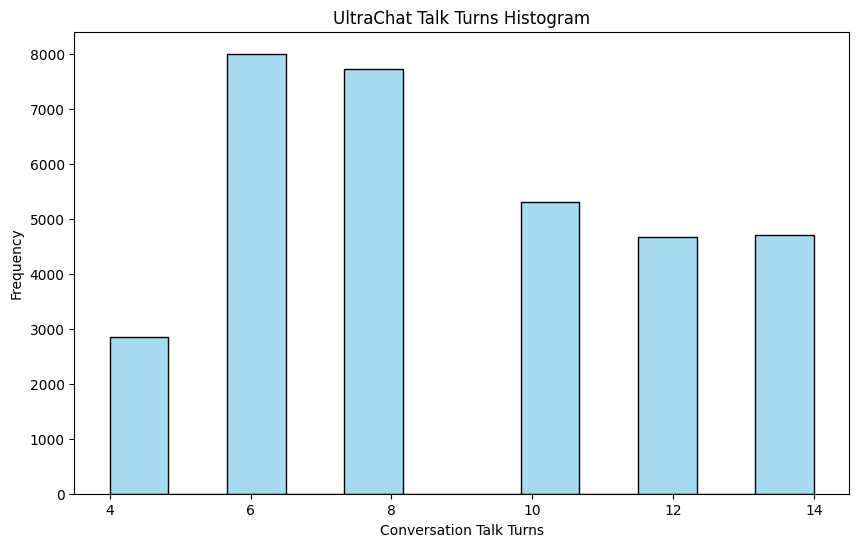

In [103]:
# Create a pandas Series
series_data = conv['conv_len']

# Create a pretty bar chart with adjusted binwidth
plt.figure(figsize=(10, 6))  # Set the figure size (adjust as needed)
sns.histplot(data=series_data, bins='auto', color='skyblue', binwidth=.8)  # Adjust the binwidth

# Add labels and title
plt.xlabel('Conversation Talk Turns')
plt.ylabel('Frequency')
plt.title('UltraChat Talk Turns Histogram')

plt.savefig(f'{output_dir}/UltraChat Talk Turns Histogram.png')
plt.show()

# NER Model

In [102]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [218]:
tqdm.pandas(desc="Processing...")
qa['ner_dict'] = qa['combined'].progress_apply(nlp)

Processing...: 100%|████████████████████████| 4434/4434 [28:58<00:00,  2.55it/s]


In [219]:
def ner_results(list, COUNT=COUNT):

    df = pd.DataFrame(list)

    try:
        filtered_df = df[(df['entity'] == 'B-LOC') | (df['entity'] == 'I-LOC')]

        #recontructs so that B-LOC and I-LOC are continuous strings
        location_entities = []
        current_entity = ""
        
        # Define a function to split concatenated entities
        def split_entities(entity):
            # Use regular expressions to split entities by camel case and word boundaries
            return ' '.join(re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', entity))
        
        for i, row in filtered_df.iterrows():
            token, label = row['word'], row['entity']
            if label == 'B-LOC':
                if current_entity:
                    split = split_entities(current_entity)
                    location_entities.append(split)
                token = token.replace('##', '')
                current_entity = token
            elif label == 'I-LOC':
                token = token.replace('##', '')
                current_entity += token
                split = split_entities(current_entity)
            else:
                if current_entity:
                    split = split_entities(current_entity)
                    location_entities.append(split)
                current_entity = ""
    
        return location_entities #return list of combined entities

    except:
        pass

In [220]:
# Function to replace empty lists and None with None
def replace_empty_list_and_none(value):
    if value is None or (isinstance(value, list) and len(value) == 0):
        return None
    return value

# Function to replace empty lists and None with None
def len_exc_null(value):
    try:
        return len(value)
    except:
        return None

In [221]:
tqdm.pandas(desc="Processing...")
qa['ner_results'] = qa['ner_dict'].progress_apply(ner_results)
qa['ner_num'] = qa['ner_results'].apply(len_exc_null)
qa.head()

Processing...: 100%|███████████████████████| 4434/4434 [00:04<00:00, 910.23it/s]


,source,filename,data,combined,cause_clean,bert_summary,ner_dict,ner_results,ner_num
0,reddit,travel_hot_100_2023-11-12,{'title': 'Passport Questions & Issues Megathr...,Passport Questions & Issues Megathread (2023) ...,passport question issue megathread 2023 note o...,day s passport en n for fucking any i check ca...,"[{'entity': 'B-ORG', 'score': 0.8285721, 'inde...",[],0.0
1,reddit,travel_hot_100_2023-11-12,"{'title': 'U.S. Department of State - ""Worldwi...","U.S. Department of State - ""Worldwide Caution""...",u s department of state worldwide caution u s ...,few in hear go it club american worry be wear ...,"[{'entity': 'B-ORG', 'score': 0.9946279, 'inde...","[S, , , S, Camden]",5.0
2,reddit,travel_hot_100_2023-11-12,{'title': '[Update] Jewelry stolen from luggag...,[Update] Jewelry stolen from luggage First of ...,update jewelry steal from luggage first of all...,protection of a both his can nalthough chatgpt...,"[{'entity': 'B-LOC', 'score': 0.99967766, 'ind...","[Rome, S]",2.0
3,reddit,travel_hot_100_2023-11-12,{'title': 'Just me or is the US now far and aw...,Just me or is the US now far and away the most...,just me or be the u now far and away the most ...,service uk to each destination low fly or to c...,"[{'entity': 'B-LOC', 'score': 0.9990816, 'inde...","[US, Europe, Asia, Mexico, NYC, Miami, Vegas, ...",17.0
4,reddit,travel_hot_100_2023-11-12,{'title': 'We need to be more supportive of ea...,We need to be more supportive of each other IR...,we need to be more supportive of each other ir...,read i not someone travel to that bad do gauch...,"[{'entity': 'B-ORG', 'score': 0.97460383, 'ind...",[],0.0


In [222]:
count = qa['ner_results'].isna().sum()
print(f'{count} documents had no location named entity detected.')

220 documents had no location named entity detected.


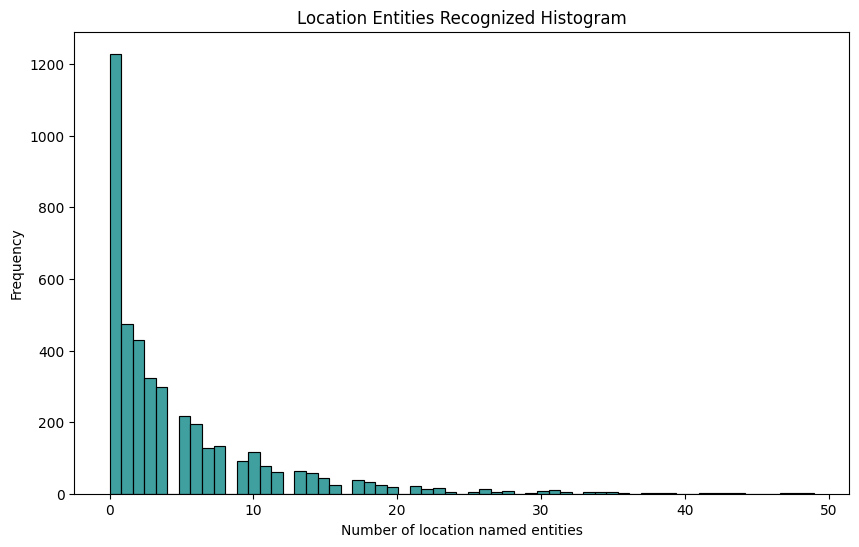

In [223]:
# Create a pandas Series
series_data = qa['ner_num']

# Create a pretty bar chart with adjusted binwidth
plt.figure(figsize=(10, 6))  # Set the figure size (adjust as needed)
sns.histplot(data=series_data, bins='auto', color='teal', binwidth=.8)  # Adjust the binwidth

# Add labels and title
plt.xlabel('Number of location named entities')
plt.ylabel('Frequency')
plt.title('Location Entities Recognized Histogram')

plt.savefig(f'{output_dir}/ner_histogram.png')
plt.show()

In [224]:
joblib.dump(qa, f'{output_dir}/ner_rec_sys.pkl')

['/media/joeymeyer/970-evo-plus/Sonia/bertproj/rec_sys/ner_rec_sys.pkl']

In [225]:
qa = joblib.load(f'{output_dir}/ner_rec_sys.pkl')

# Reference
https://huggingface.co/dslim/bert-base-NER